<a href="https://colab.research.google.com/github/senguptashritama/Multilabel-Classification-of-ResearchPapers/blob/main/SVM_LabelPowerSet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Loading required libraries and preprocessed dataset

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
! pip install scikit-multilearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 1.1 MB/s eta 0:00:00


In [ ]:
import gensim
import numpy as np
import pandas as pd
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from skmultilearn.problem_transform import LabelPowerset
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/archive (4)/filtered_data.csv")
df.tail()

,titles,summaries,terms
28203,covariance estimation use conjugate gradient 3...,classify structural variability noisy projecti...,['cs.CV']
28204,orthogonal matrix retrieval cryoelectron micro...,single particle reconstruction spr cryoele...,['cs.CV']
28205,raybase approach boundary estimation fiber bun...,diffusion tensor imaging dti noninvasive i...,['cs.CV']
28206,statistical denoise single molecule fluorescen...,single molecule fluorescence microscopy powerf...,['cs.CV']
28207,semiautomatic graphbased approach determine bo...,diffusion tensor imaging dti allow estimat...,['cs.CV']


In [ ]:
# Removing quotation marks from the terms in the 'terms' column
df['terms'] = df['terms'].str.replace("'", "")

In [ ]:
df['terms']

0               [cs.CV, cs.LG]
1        [cs.CV, cs.AI, cs.LG]
2               [cs.CV, cs.AI]
3                      [cs.CV]
4               [cs.CV, cs.LG]
                 ...          
28203                  [cs.CV]
28204                  [cs.CV]
28205                  [cs.CV]
28206                  [cs.CV]
28207                  [cs.CV]
Name: terms, Length: 28208, dtype: object

### Creating word embedding of the input text (titles and summaries) using Word2Vec

In [ ]:
df['text'] = df['titles'] + ' ' + df['summaries']

df['tokens'] = df['text'].apply(word_tokenize)
model = Word2Vec(sentences= df['tokens'], vector_size=100, window=5, min_count=1, sg=0)
model.save("word2vec_arxiv.model")

In [ ]:
word2vec_model = Word2Vec.load("word2vec_arxiv.model")


def text_to_vectors(text, word2vec_model):
    words = text.split()
    vector = np.zeros(word2vec_model.vector_size)
    for word in words:
        if word in word2vec_model.wv:
            vector += word2vec_model.wv[word]
    if np.count_nonzero(vector) == 0:
        return vector
    else:
        return vector / np.linalg.norm(vector)

df["titles"] = df["titles"].apply(lambda x: text_to_vectors(x, word2vec_model))
df["summaries"] = df["summaries"].apply(lambda x: text_to_vectors(x, word2vec_model))

In [ ]:
df.head()

,titles,summaries,terms,text,tokens
0,"[0.039591500602298366, 0.1236408425616035, 0.1...","[0.003352175112100147, 0.14053153652067799, 0....","[cs.CV, cs.LG]",survey semantic stereo match semantic depth ...,"[survey, semantic, stereo, match, semantic, de..."
1,"[-0.0007615696904282532, 0.08509950844247012, ...","[0.02400992015074885, 0.10354375047945412, -0....","[cs.CV, cs.AI, cs.LG]",futureai guide principle consensus recommend...,"[futureai, guide, principle, consensus, recomm..."
2,"[0.03195785099968652, 0.13072572676305488, 0.1...","[0.07844068625372622, 0.20091479652133606, 0.0...","[cs.CV, cs.AI]",enforce mutual consistency hard region semisup...,"[enforce, mutual, consistency, hard, region, s..."
3,"[0.01848393439530517, 0.14030007358970942, -0....","[0.031950456623466586, 0.25492296579591595, 0....",[cs.CV],parameter decoupling strategy semisupervise 3d...,"[parameter, decoupling, strategy, semisupervis..."
4,"[0.051954410106676986, 0.05101692023315958, -0...","[0.10094770325751207, 0.15707009673172095, -0....","[cs.CV, cs.LG]",backgroundforeground segmentation interior sen...,"[backgroundforeground, segmentation, interior,..."


In [ ]:
df['terms']

0               [cs.CV, cs.LG]
1        [cs.CV, cs.AI, cs.LG]
2               [cs.CV, cs.AI]
3                      [cs.CV]
4               [cs.CV, cs.LG]
                 ...          
28203                  [cs.CV]
28204                  [cs.CV]
28205                  [cs.CV]
28206                  [cs.CV]
28207                  [cs.CV]
Name: terms, Length: 28208, dtype: object

### Encoding target variable using MultilabelBinarizer

In [ ]:
terms_split = df['terms'].str.strip('][').str.split(', ')

mlb = MultiLabelBinarizer()
y_encoded = pd.DataFrame(mlb.fit_transform(terms_split), columns=mlb.classes_)
print(mlb.classes_)


['cs.AI' 'cs.CV' 'cs.LG' 'eess.IV' 'stat.ML']


In [ ]:
y_encoded

,cs.AI,cs.CV,cs.LG,eess.IV,stat.ML
0,0,1,1,0,0
1,1,1,1,0,0
2,1,1,0,0,0
3,0,1,0,0,0
4,0,1,1,0,0
...,...,...,...,...,...
28203,0,1,0,0,0
28204,0,1,0,0,0
28205,0,1,0,0,0
28206,0,1,0,0,0


### Merging the encoded columns to one dataframe

In [ ]:
combined_data = pd.concat([df, y_encoded], axis=1)

In [ ]:
combined_data.tail()

,titles,summaries,terms,text,tokens,cs.AI,cs.CV,cs.LG,eess.IV,stat.ML
28203,"[0.048572606901945974, 0.1882794822376859, 0.0...","[0.004770712251292086, 0.14748266013845487, 0....",[cs.CV],covariance estimation use conjugate gradient 3...,"[covariance, estimation, use, conjugate, gradi...",0,1,0,0,0
28204,"[-0.20025591161938983, 0.1356884298879479, 0.1...","[-0.08218648266020549, 0.2188443765368251, 0.0...",[cs.CV],orthogonal matrix retrieval cryoelectron micro...,"[orthogonal, matrix, retrieval, cryoelectron, ...",0,1,0,0,0
28205,"[-0.04913371617849904, 0.20285396994893912, 0....","[-0.08631998419059149, 0.1911312227208635, 0.1...",[cs.CV],raybase approach boundary estimation fiber bun...,"[raybase, approach, boundary, estimation, fibe...",0,1,0,0,0
28206,"[-0.0268654291725162, 0.11633432453745857, 0.1...","[-0.0010062773670705687, 0.20174472627383333, ...",[cs.CV],statistical denoise single molecule fluorescen...,"[statistical, denoise, single, molecule, fluor...",0,1,0,0,0
28207,"[0.030059774914638907, 0.16276666493193384, -0...","[-0.042486515633083824, 0.19987005795399232, 0...",[cs.CV],semiautomatic graphbased approach determine bo...,"[semiautomatic, graphbased, approach, determin...",0,1,0,0,0


### Preparing predictor variables (X) and target variables (Y) for model training

In [ ]:
x_data = combined_data[['titles','summaries']].values
X =  np.array(x_data.tolist())
X = X.reshape(X.shape[0], -1)

In [ ]:
X

array([[ 0.0395915 ,  0.12364084,  0.14519658, ..., -0.01973697,
        -0.17829854,  0.01662667],
       [-0.00076157,  0.08509951, -0.11003805, ..., -0.08940165,
        -0.1205043 ,  0.09297674],
       [ 0.03195785,  0.13072573,  0.12422526, ...,  0.0766971 ,
        -0.18197315,  0.00346556],
       ...,
       [-0.04913372,  0.20285397,  0.15288389, ..., -0.02299254,
        -0.13413086, -0.02721   ],
       [-0.02686543,  0.11633432,  0.13040892, ...,  0.11193822,
        -0.23577859,  0.06063797],
       [ 0.03005977,  0.16276666, -0.03920614, ..., -0.06266194,
        -0.09222356,  0.00687263]])

In [ ]:
y_data = combined_data[['cs.AI','cs.CV','cs.LG','eess.IV','stat.ML']].values
y =  np.array(y_data.tolist())

In [ ]:
# train-test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Calculating costs based on class frequencies

In [ ]:
class_frequencies = y_train.mean(axis=0)
label_costs = 1 / class_frequencies

In [ ]:
label_costs

array([ 7.3504886 ,  1.54752435,  2.03169173, 21.03075489,  3.52373517])

### Model Training

First we define a Support Vector Classifier (SVC) with linear kernel and assign class weights based on label costs. Next, we encapsulate the SVC within the Label Powerset framework. Finally, we train the Label Powerset classifier on the training data (X_train, y_train).

In [ ]:
# Step 1: Define SVC classifier
base_classifier = SVC(class_weight=dict(enumerate(label_costs)), kernel='linear')

# Step 2: Wrap the base classifier into Label Powerset
svm_model = LabelPowerset(classifier=base_classifier)

# Step 3: Fit the Label Powerset classifier on the training data
svm_model.fit(X_train, y_train)

LabelPowerset(classifier=SVC(class_weight={0: 7.350488599348535,
                                           1: 1.547524345082979,
                                           2: 2.031691725938597,
                                           3: 21.030754892823857,
                                           4: 3.5237351655215488},
                             kernel='linear'),
              require_dense=[True, True])

In [ ]:
y_pred = svm_model.predict(X_test)
y_pred

<5642x5 sparse matrix of type '<class 'numpy.int64'>'
	with 8046 stored elements in List of Lists format>

Let us print the predicted output labels against the actual labels to see if we are getting correct output.

In [ ]:
# Assuming label_mapping is a dictionary mapping integer labels to string labels
label_mapping = {0: 'cs.AI', 1: 'cs.CV', 2: 'cs.LG', 3: 'eess.IV', 4: 'stats.ML'}

# Print actual vs predicted labels with string labels
for i in range(min(15, y_test.shape[0])):  # Print for the first few samples
    actual_labels = [label_mapping[j] for j in range(y_test.shape[1]) if y_test[i, j] == 1]
    predicted_labels = [label_mapping[j] for j in range(y_pred_dense.shape[1]) if y_pred_dense[i, j] == 1]
    print("Sample", i+1)
    print("Actual Labels:", actual_labels)
    print("Predicted Labels:", predicted_labels)
    print()

Sample 1
Actual Labels: ['cs.LG', 'stats.ML']
Predicted Labels: ['cs.LG', 'stats.ML']

Sample 2
Actual Labels: ['cs.CV']
Predicted Labels: ['cs.CV']

Sample 3
Actual Labels: ['cs.AI', 'cs.LG', 'stats.ML']
Predicted Labels: ['cs.LG', 'stats.ML']

Sample 4
Actual Labels: ['cs.CV']
Predicted Labels: ['cs.CV']

Sample 5
Actual Labels: ['cs.CV', 'eess.IV']
Predicted Labels: ['cs.CV']

Sample 6
Actual Labels: ['cs.CV']
Predicted Labels: ['cs.CV']

Sample 7
Actual Labels: ['cs.LG']
Predicted Labels: ['cs.LG', 'stats.ML']

Sample 8
Actual Labels: ['cs.CV']
Predicted Labels: ['cs.CV']

Sample 9
Actual Labels: ['cs.LG', 'stats.ML']
Predicted Labels: ['cs.LG', 'stats.ML']

Sample 10
Actual Labels: ['cs.CV']
Predicted Labels: ['cs.CV']

Sample 11
Actual Labels: ['cs.CV', 'cs.LG']
Predicted Labels: ['cs.CV']

Sample 12
Actual Labels: ['cs.CV', 'cs.LG', 'stats.ML']
Predicted Labels: ['cs.LG', 'stats.ML']

Sample 13
Actual Labels: ['cs.CV']
Predicted Labels: ['cs.CV']

Sample 14
Actual Labels: ['cs.A

We can see that the model can capture maximum upto 2 labels and not more.

### Model Evaluation

1) ROC Curve

2) Balanced accuracy and F1 score

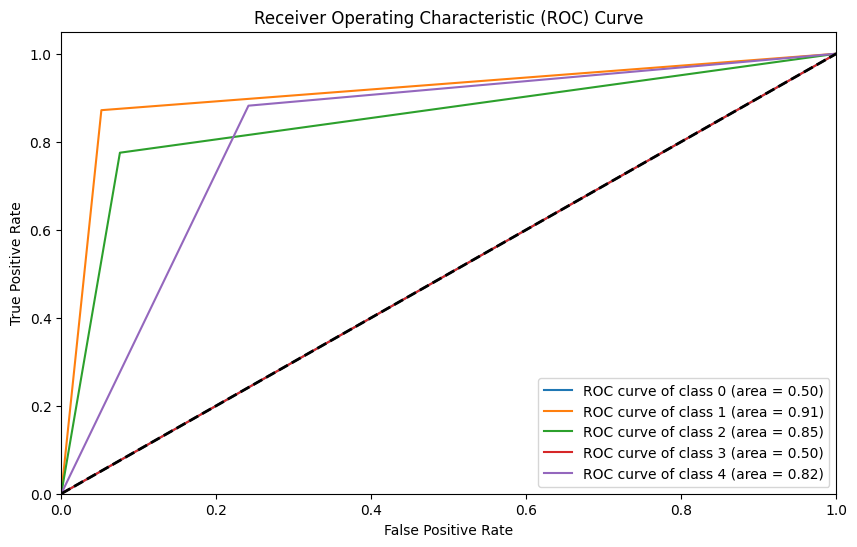

In [ ]:
y_pred_dense = y_pred.toarray()

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(y_test.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_dense[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 6))
for i in range(y_test.shape[1]):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

ROC AUC (Area Under the Curve) of 0.50 to 0.70 suggests poor discrimination.

ROC AUC of 0.70 to 0.80 suggests fair discrimination.

ROC AUC of 0.80 to 0.90 suggests good discrimination.

ROC AUC above 0.90 suggests excellent discrimination.


Hence class 0 and class 3 i.e cs.CV and eess.IV having an ROC curve area of 0.50 indicatesthe model's performance is no better than random chance.

Rest of the labels are having good discrimination.

In [ ]:
from sklearn.metrics import accuracy_score

# Assuming y_true contains true labels and y_pred contains predicted labels

# Compute balanced accuracy score for each label
balanced_acc_scores = []
for i in range(y_test.shape[1]):
    balanced_acc_scores.append(accuracy_score(y_test[:, i], y_pred_dense[:, i]))

# Compute average balanced accuracy score
average_balanced_acc_score = np.mean(balanced_acc_scores)

print("Average Balanced Accuracy Score:", average_balanced_acc_score)

Average Balanced Accuracy Score: 0.8712158808933003


In [ ]:
from sklearn.metrics import f1_score

# Compute F1 score for each label
f1_scores = []
for i in range(y_test.shape[1]):
    f1_scores.append(f1_score(y_test[:, i], y_pred_dense[:, i]))

# Compute average F1 score
average_f1_score = np.mean(f1_scores)

print("Average F1 Score:", average_f1_score)

Average F1 Score: 0.49327138305725615


**Final Note -** In summary, the F1 score indicates moderate performance in terms of precision and recall, while the high accuracy suggests overall good performance in predicting the majority class.